## Statoli Iceberg Challenge


### Import libraries


In [2]:
import numpy as np
import os
import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import FileLink
from keras.preprocessing.image import ImageDataGenerator
from subprocess import check_output
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, \
                         GlobalMaxPooling2D, concatenate, BatchNormalization, Permute, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from IPython.display import display
from keras.utils import to_categorical
from keras import backend as K
from keras.utils import plot_model
import datetime
import math
import seaborn as sns
from pylab import rcParams
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

RANDSEED = 656
np.random.seed(RANDSEED)

#sns.set() #reset 
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

rcParams['figure.figsize'] = 14, 8

%matplotlib inline

In [3]:
K.set_image_dim_ordering('tf')

### Load & visualize data

In [4]:
#Load data
train = pd.read_json("/home/odenigborig/Data/kaggle/statoli_iceberg/data/processed/train.json")
test = pd.read_json("/home/odenigborig/Data/kaggle/statoli_iceberg/data/processed/test.json")

In [5]:
#let's see what the data looks like
print("# Training set: ", len(train))
display(train.tail().transpose())
print("")

print("# Test set: ", len(test))
display(test.tail().transpose())


('# Training set: ', 1604)


,1599,1600,1601,1602,1603
band_1,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-25.31155, -26.511555, -28.694487, -27.180115...","[-18.141895, -18.141844, -19.01737, -19.701599...","[-22.455633, -25.794661, -26.954567, -22.83354...","[-19.909191, -20.678406, -20.208834, -18.42441..."
band_2,"[-27.847719, -28.233864, -24.712078, -24.45282...","[-29.563713, -28.290375, -26.839405, -28.29046...","[-25.305355, -29.387701, -28.963863, -26.16023...","[-26.070356, -22.093737, -21.577662, -24.53376...","[-24.44487, -24.956001, -27.722103, -26.078417..."
id,04e11240,c7d6f6f8,bba1a0f1,7f66bb44,9d8f326c
inc_angle,na,na,na,na,na
is_iceberg,0,0,0,0,0



('# Test set: ', 8424)


,8419,8420,8421,8422,8423
band_1,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-21.0313911438, -21.0313911438, -21.031391143...","[-28.609278, -26.514626, -26.514679, -26.83061...","[-27.068821, -27.068892, -23.970854, -22.38730...","[-25.4388656616, -25.4388656616, -25.438865661..."
band_2,"[-25.860718, -23.29442, -25.860861, -25.334354...","[-23.7558364868, -23.7558364868, -23.755836486...","[-28.609278, -29.437183, -30.35239, -31.375494...","[-29.991381, -29.163599, -24.886002, -27.71266...","[-23.8552780151, -23.8552780151, -23.855278015..."
id,16ee9b50,5a599eb7,df30d6dd,18af95b1,27d788c8
inc_angle,34.7955,32.2467,39.5032,33.638,36.7582


Notice the training set is significantly smaller  than the test set. This will be challenging because I also want to make an internal validation and test set as well. 

I will try a few things:
- fully connected layers dense layers - to get baseline performance
    - try shallow network such as random forest or svm
- small convolutional neural network (CNN)
- image (data) augmentation - i.e. make more images
- K-fold validation
- use pretrained CNN model such as VGG

From the display of the data above, notice that there are missing data (na) present in the training inc_angle. Using describe() we can see that that there are about 133 'na' entries. 
- might consider deleting these. 

In [6]:
display(train.inc_angle.describe())
display(test.inc_angle.describe())

count     1604
unique     879
top         na
freq       133
Name: inc_angle, dtype: object

count    8424.000000
mean       40.153403
std         4.108386
min        23.080500
25%        36.905200
50%        40.375790
75%        43.472950
max        50.661785
Name: inc_angle, dtype: float64

In [7]:
#replace na with zeros in inc_angle (incline) columne
train.inc_angle = train.inc_angle.replace('na', 0) 
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

test.inc_angle = test.inc_angle.replace('na', 0) 
test.inc_angle = test.inc_angle.astype(float).fillna(0.0)

display(train.inc_angle.describe())
display(test.inc_angle.describe())


count    1604.000000
mean       36.012636
std        11.439109
min         0.000000
25%        35.295400
50%        38.886100
75%        42.512800
max        45.937500
Name: inc_angle, dtype: float64

count    8424.000000
mean       40.153403
std         4.108386
min        23.080500
25%        36.905200
50%        40.375790
75%        43.472950
max        50.661785
Name: inc_angle, dtype: float64

The data is reasonably balanced, about the same number of iceberg and no-iceberg conditions.

In [8]:
iceberg = train[train['is_iceberg']==1]
no_iceberg = train[train['is_iceberg'] == 0]

print('# Iceberg: {} '.format(len(iceberg)))
print('# No Iceberg: {} '.format(len(no_iceberg)))

# Iceberg: 753 
# No Iceberg: 851 


Let's plot the angles for iceberg and no iceberg

(0, 50)

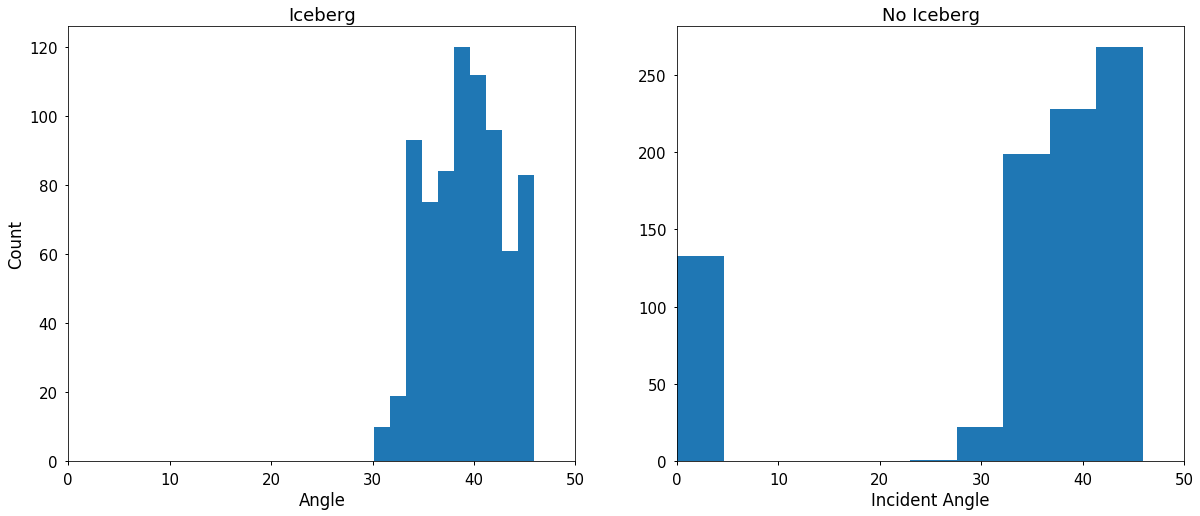

In [9]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

iceberg_angle  = np.asarray(iceberg['inc_angle'])
no_iceberg_angle  = np.asarray(no_iceberg['inc_angle'])

ax1.hist(iceberg_angle)
ax2.hist(no_iceberg_angle)

ax1.set_title('Iceberg')
ax2.set_title('No Iceberg')
ax1.set_xlabel('Angle')
ax2.set_xlabel('Incident Angle')
ax1.set_ylabel('Count')
ax1.set_xlim(0,50)
ax2.set_xlim(0,50)

Let's plot a few example images of iceberg and no iceberg to visualize 

In [10]:
def normalize_img(band):
    """
    normalize input data and reshape into image
    """
    #convert to numpy array and float32
    band_out = np.array(band).astype(np.float32)
    
    #normalize from 0 to 1
    band_out = 1e-3 + ((band_out - band_out.min()) / (band_out.max() - band_out.min()))

    #reshape as image
    band_out = band_out.reshape(75,75)

    return band_out

Run #: 0
Run #: 1
Run #: 2


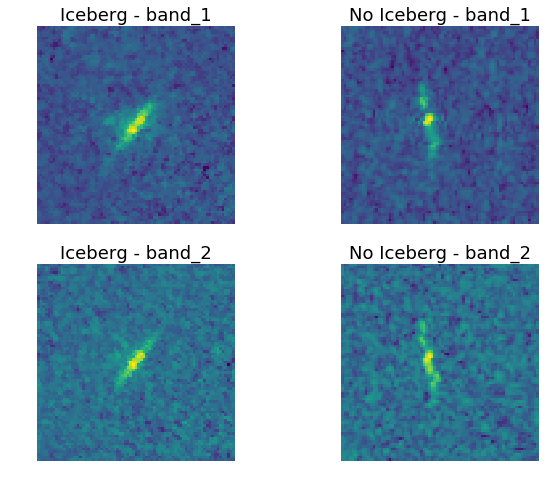

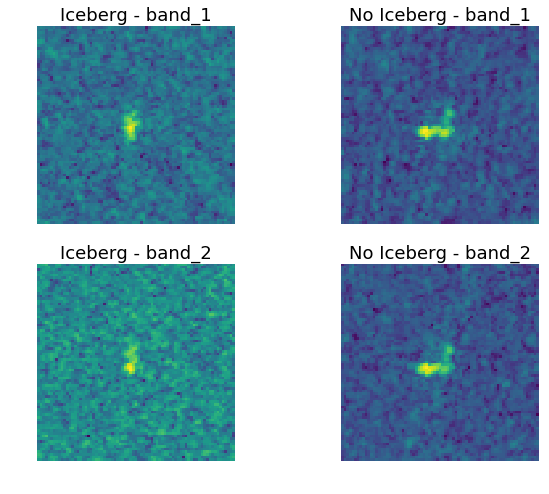

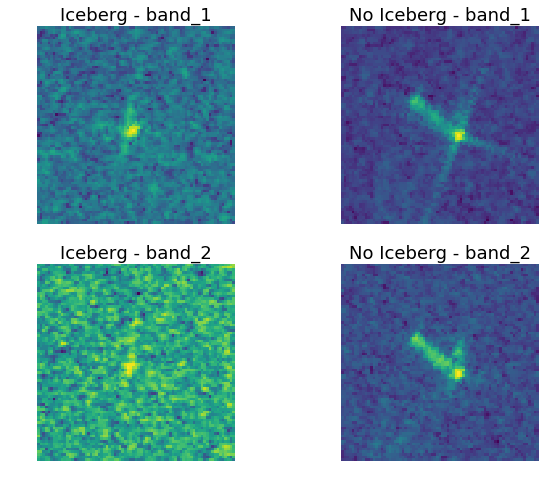

In [11]:
iceberg = shuffle(iceberg)
no_iceberg = shuffle(no_iceberg)

for ii in range(3):
    print('Run #: {}'.format(ii))
    f = plt.figure(figsize=(10,8))

    #plot iceberg
    band_1 = normalize_img(iceberg['band_1'].values[ii])
    band_2 = normalize_img(iceberg['band_2'].values[ii])

    ax1 = f.add_subplot(2,2,1)

    plt.imshow(band_1)
    ax1.axis('off')
    ax1.set_title('Iceberg - band_1')

    ax2 = f.add_subplot(2,2,3)
    plt.imshow(band_2)
    ax2.axis('off')
    ax2.set_title('Iceberg - band_2')


    #plot no iceberg
    band_1 = normalize_img(no_iceberg['band_1'].values[ii])
    band_2 = normalize_img(no_iceberg['band_2'].values[ii])

    ax1 = f.add_subplot(2,2,2)

    plt.imshow(band_1)
    ax1.axis('off')
    ax1.set_title('No Iceberg - band_1')

    ax2 = f.add_subplot(2,2,4)
    plt.imshow(band_2)
    ax2.axis('off')
    ax2.set_title('No Iceberg - band_2')



Running the above cell a few times, notice that it's not obvious to distinguish iceberg from no iceberg (i.e. ship) conditions. 

## Data preparation

In [12]:
def preprocess_images(df):
    band1 = np.array([band for band in df["band_1"]])
    band2 = np.array([band for band in df["band_2"]])
    band3 = band1 / band2

    ch1 = []
    ch2 = []
    ch3 = []

    for i in range(len(df)):
        ch1.append(normalize_img(band1[i,:]))
        ch2.append(normalize_img(band2[i,:]))
        ch3.append(normalize_img(band3[i,:]))

    ch1 = np.array(ch1)
    ch2 = np.array(ch2)
    ch3 = np.array(ch3)

    output = np.concatenate([ch1[:,:,:,np.newaxis],ch2[:,:,:,np.newaxis],ch3[:,:,:,np.newaxis]],axis=-1)

    return output

In [13]:
#Prepare training data
X_TRAIN = preprocess_images(train)
X_ANGLE_TRAIN = np.array(train.inc_angle)
Y_TRAIN = np.array(train["is_iceberg"])

#Prepare test data
X_KagTest = preprocess_images(test)
X_KagTest_angle = np.array(test.inc_angle)

#check size
print(X_TRAIN.shape)
print(X_KagTest.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)


In [ ]:
# split into internal train, validation, and test
train_len  = X_TRAIN.shape[0]
inds = shuffle(np.array(range(train_len)),random_state=RANDSEED)
split = 0.8
train_inds = inds[0:int(train_len*split)]
valid_inds = inds[int(train_len*split):]

X_train = X_TRAIN[train_inds,:,:,:]
X_valid = X_TRAIN[valid_inds,:,:,:]
print('Data Imgs:')
print(X_train.shape)
print(X_valid.shape)


X_angle_train = X_ANGLE_TRAIN[train_inds,]
X_angle_valid = X_ANGLE_TRAIN[valid_inds,]
print('Angles:')
print(X_angle_train.shape)
print(X_angle_valid.shape)

y_train = Y_TRAIN[train_inds,]
y_valid = Y_TRAIN[valid_inds,]
print('Labels:')
print(y_train.shape)
print(y_valid.shape)


## Create CNN model
Create a generic model from which we can build from. 

In [26]:
def cnn_model(img_input_shape=(75,75,3),base_filters=8,cnn_layers=4,p_dropout=(0,0), \
              dense_units=(32,32),p_activation='elu'):
        
    img_input = Input(shape=img_input_shape, name="image_input")
    angle_input = Input(shape=(1,), name="input_angle")

    cnn = Permute([1,2,3],name='permute')(img_input)
    cnn = BatchNormalization(axis=1,name='bn_0')(cnn)

    for i in range(cnn_layers):
        cnn = Conv2D(filters=base_filters*2**(3+i), kernel_size=(3, 3), activation=p_activation, 
                     padding='same',name='conv_' + str(1+i) + '_1')(cnn)
        cnn = BatchNormalization(axis=1,name='bn_' + str(i+1) + '_1')(cnn)
        cnn = Conv2D(filters=base_filters*2**(3+i), kernel_size=(3, 3), activation=p_activation,
                     padding='same',  name='conv_' + str(1+i) + '_2')(cnn)
        cnn = BatchNormalization(axis=1,name='bn_' + str(i+1) + '_2')(cnn)

        #print(cnn._keras_shape)
        cnn = MaxPooling2D((2,2), strides=(2,2), name='max_pool_' + str(1+i))(cnn)
        cnn = Dropout(p_dropout,name='dropout_'+str(i+1))(cnn)
        #print(cnn._keras_shape)
    
    #flatten = Flatten(name='flatten')(cnn)
    flatten = GlobalAveragePooling2D(name='flatten')(cnn)
    #print(flatten._keras_shape)

    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    fc = concatenate([flatten, angle_input],axis=-1,name='concat')
    #print(merge._keras_shape)

    #fully connected layers
    for d in range(len(dense_units)):
        fc = Dense(dense_units[d],activation=p_activation,name='fully_connected_' + str(d+1))(fc)
        fc = Dropout(p_dropout[d],name='dropout_'+str(d+i+2))(fc)
        #print(fc._keras_shape)

    output = Dense(1, activation='sigmoid',name='output')(fc)
    #output = Dropout(p_dropout)(fc)
    #print(fc._keras_shape)

    model = Model(inputs=[img_input, angle_input], outputs=output,name='CNN')
    model.summary()
    
    return model



## Fit model

In [15]:
def plot_loss(history_model):
    f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
    ax1.plot(history_model.history['val_loss'],label='valid')
    ax1.plot(history_model.history['loss'],label='train')
    ax2.plot(history_model.history['val_acc'],label='valid')
    ax2.plot(history_model.history['acc'],label='train')

    ax1.legend()
    ax2.legend()
    plt.xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')

def print_score(model,X,angle,y,label='Hold out'):
    score = model.evaluate([X, angle], y, verbose=1)
    print('')
    print(label + ' score: {:.2f}'.format(score[0]))
    print(label + ' accuracy {:.2f}%:'.format(100*score[1]))


In [16]:
path = os.getcwd()
model_path = path + '/models/'
file_path = model_path + ".model5_weights.hdf5"


In [16]:
batch_size = 64
epochs = 100
patience = 10

es = EarlyStopping('val_loss', patience=patience, mode="min")
msave = ModelCheckpoint(file_path, save_best_only=True, monitor='val_loss',mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=1/3., patience=7, verbose=1, epsilon=1e-4, mode='min')   

callbacks = [es, msave, reduce_lr_loss]

In [29]:
model = cnn_model(base_filters=2,cnn_layers=4,dense_units=(512,256))
model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

history_model = model.fit(x=[X_train, X_angle_train], y=y_train, epochs=epochs,
                          validation_data=([X_valid, X_angle_valid], y_valid), 
                          batch_size=batch_size, callbacks = callbacks,verbose=2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 75, 75, 3)    0           image_input[0][0]                
__________________________________________________________________________________________________
bn_0 (BatchNormalization)       (None, 75, 75, 3)    300         permute[0][0]                    
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 75, 75, 16)   448         bn_0[0][0]                       
__________________________________________________________________________________________________
bn_1_1 (Ba

Epoch 9/50
 - 86s - loss: 0.3830 - acc: 0.8153 - val_loss: 0.5347 - val_acc: 0.6916
Epoch 10/50
 - 86s - loss: 0.3612 - acc: 0.8231 - val_loss: 0.4998 - val_acc: 0.7352
Epoch 11/50
 - 86s - loss: 0.3349 - acc: 0.8410 - val_loss: 0.5685 - val_acc: 0.6480
Epoch 12/50
 - 86s - loss: 0.3225 - acc: 0.8457 - val_loss: 0.5631 - val_acc: 0.6542
Epoch 13/50
 - 86s - loss: 0.2970 - acc: 0.8628 - val_loss: 0.5239 - val_acc: 0.6978
Epoch 14/50
 - 86s - loss: 0.2914 - acc: 0.8620 - val_loss: 0.5551 - val_acc: 0.6885
Epoch 15/50
 - 86s - loss: 0.3050 - acc: 0.8644 - val_loss: 0.7190 - val_acc: 0.6012
Epoch 16/50
 - 86s - loss: 0.3195 - acc: 0.8581 - val_loss: 0.3517 - val_acc: 0.8629
Epoch 17/50
 - 86s - loss: 0.3382 - acc: 0.8472 - val_loss: 0.3276 - val_acc: 0.8629
Epoch 18/50
 - 86s - loss: 0.2801 - acc: 0.8722 - val_loss: 0.4353 - val_acc: 0.7570
Epoch 19/50
 - 86s - loss: 0.2966 - acc: 0.8683 - val_loss: 0.4131 - val_acc: 0.7726
Epoch 20/50
 - 86s - loss: 0.2728 - acc: 0.8776 - val_loss: 0.4072

321/321 [==============================] - 10s 32ms/step

valid score: 0.35
valid accuracy 87.23%:


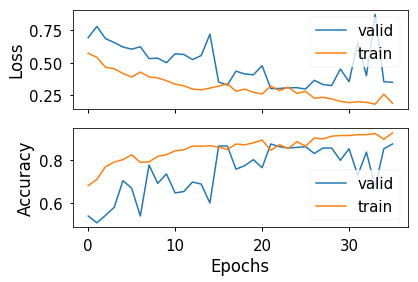

In [37]:
plot_loss(history_model)
print_score(model,X_valid,X_angle_valid,y_valid,label='valid')

In [47]:
model2 = cnn_model(base_filters=2,cnn_layers=4,dense_units=(1024,512),p_dropout=(0.5,0.1))
model2.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

history_model = model2.fit(x=[X_train, X_angle_train], y=y_train, epochs=epochs,
                          validation_data=([X_valid, X_angle_valid], y_valid), 
                          batch_size=batch_size, callbacks = callbacks,verbose=2)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 75, 75, 3)    0           image_input[0][0]                
__________________________________________________________________________________________________
bn_0 (BatchNormalization)       (None, 75, 75, 3)    300         permute[0][0]                    
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 75, 75, 16)   448         bn_0[0][0]                       
__________________________________________________________________________________________________
bn_1_1 (Ba

Epoch 9/50
 - 86s - loss: 0.5527 - acc: 0.7412 - val_loss: 0.8420 - val_acc: 0.5639
Epoch 10/50
 - 86s - loss: 0.5303 - acc: 0.7389 - val_loss: 0.7644 - val_acc: 0.6199
Epoch 11/50
 - 86s - loss: 0.5681 - acc: 0.7202 - val_loss: 0.5791 - val_acc: 0.7352
Epoch 12/50
 - 86s - loss: 0.5464 - acc: 0.7303 - val_loss: 0.6965 - val_acc: 0.6573
Epoch 13/50
 - 86s - loss: 0.5243 - acc: 0.7210 - val_loss: 0.5311 - val_acc: 0.7632
Epoch 14/50
 - 86s - loss: 0.5234 - acc: 0.7599 - val_loss: 0.5235 - val_acc: 0.7882
Epoch 15/50
 - 86s - loss: 0.5921 - acc: 0.7225 - val_loss: 0.5570 - val_acc: 0.7726
Epoch 16/50
 - 86s - loss: 0.4991 - acc: 0.7412 - val_loss: 0.5458 - val_acc: 0.7508
Epoch 17/50
 - 86s - loss: 0.4831 - acc: 0.7537 - val_loss: 0.4834 - val_acc: 0.7819
Epoch 18/50
 - 86s - loss: 0.4854 - acc: 0.7592 - val_loss: 0.6575 - val_acc: 0.6822
Epoch 19/50
 - 86s - loss: 0.4694 - acc: 0.7685 - val_loss: 0.5324 - val_acc: 0.7539
Epoch 20/50
 - 86s - loss: 0.4578 - acc: 0.7755 - val_loss: 0.4271

321/321 [==============================] - 10s 32ms/step

valid score: 0.34
valid accuracy 84.74%:


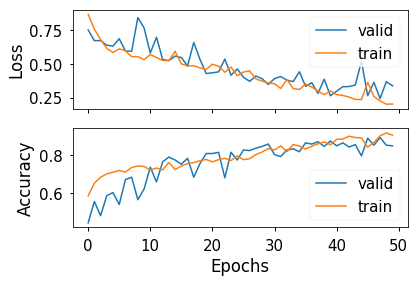

In [48]:
plot_loss(history_model)
print_score(model2,X_valid,X_angle_valid,y_valid,label='valid')

In [19]:
model.save_weights('4_layer_cnn_jan_14_no_dropout.h5')

In [ ]:
model.load_weights('4_layer_cnn_jan_14_no_dropout.h5')

### Data augmentation
- validation data should not be augmented!! (see Deep Learning w/ Python textbook)

In [14]:
gen = ImageDataGenerator(vertical_flip = True, horizontal_flip=True,zoom_range=0.1,width_shift_range=0.1,
                               height_shift_range=0.1,rotation_range=3,data_format = 'channels_last')


#Merge two generators with the same random seed
def gen_flow_two_inputs(img_data, angle_data, y_label,seed=656):
    gen1 = gen.flow(img_data,y_label, batch_size=batch_size, seed=seed)
    gen2 = gen.flow(img_data,angle_data, batch_size=batch_size, seed=seed)
    
    while True:
        X1 = gen1.next()
        X2 = gen2.next()
        
        #return batches
        yield [X1[0], X2[1]], X1[1]


In [21]:
#create generator
gen_flow_train = gen_flow_two_inputs(X_train, X_angle_train, y_train)

In [38]:
#
epochs= 50
#model = cnn_model(base_filters=2,cnn_layers=4,dense_units=(1024,512))
#model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
train_samples = len(X_train)

history_model = model.fit_generator(gen_flow_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,
                                    callbacks=callbacks,validation_data=([X_valid, X_angle_valid], y_valid))


Epoch 1/50
3/3 [==============================] - 22s 7s/step - loss: 0.5001 - acc: 0.7448 - val_loss: 0.2756 - val_acc: 0.8910
Epoch 2/50
3/3 [==============================] - 22s 7s/step - loss: 0.3939 - acc: 0.7969 - val_loss: 0.3198 - val_acc: 0.8629
Epoch 3/50
3/3 [==============================] - 18s 6s/step - loss: 0.7085 - acc: 0.6027 - val_loss: 0.7732 - val_acc: 0.6480
Epoch 4/50
3/3 [==============================] - 22s 7s/step - loss: 0.7158 - acc: 0.7240 - val_loss: 0.2976 - val_acc: 0.8629
Epoch 5/50
3/3 [==============================] - 22s 7s/step - loss: 0.4072 - acc: 0.8229 - val_loss: 0.7615 - val_acc: 0.7321
Epoch 6/50
3/3 [==============================] - 22s 7s/step - loss: 0.5154 - acc: 0.7969 - val_loss: 0.7145 - val_acc: 0.7570
Epoch 7/50
3/3 [==============================] - 22s 7s/step - loss: 0.5327 - acc: 0.8021 - val_loss: 0.2955 - val_acc: 0.8536
Epoch 8/50
3/3 [==============================] - 22s 7s/step - loss: 0.4431 - acc: 0.8125 - val_loss: 0

321/321 [==============================] - 10s 32ms/step

valid score: 0.37
valid accuracy 83.49%:


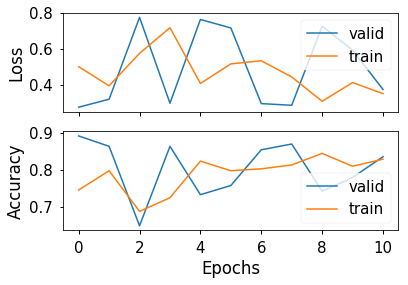

In [39]:
plot_loss(history_model)
print_score(model,X_valid,X_angle_valid,y_valid,label='valid')

In [52]:
gen_flow_train = gen_flow_two_inputs(X_train, X_angle_train, y_train)
train_samples = len(X_train)
history_model = model2.fit_generator(gen_flow_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,
                                    callbacks=callbacks,validation_data=([X_valid, X_angle_valid], y_valid))

Epoch 1/50
20/20 [==============================] - 87s 4s/step - loss: 0.3714 - acc: 0.8422 - val_loss: 0.2308 - val_acc: 0.8910
Epoch 2/50
20/20 [==============================] - 83s 4s/step - loss: 0.3443 - acc: 0.8387 - val_loss: 0.2360 - val_acc: 0.8879
Epoch 3/50
20/20 [==============================] - 83s 4s/step - loss: 0.3191 - acc: 0.8528 - val_loss: 0.2389 - val_acc: 0.8941
Epoch 4/50
20/20 [==============================] - 83s 4s/step - loss: 0.3828 - acc: 0.8243 - val_loss: 0.3108 - val_acc: 0.8536
Epoch 5/50
20/20 [==============================] - 83s 4s/step - loss: 0.3810 - acc: 0.8228 - val_loss: 0.3738 - val_acc: 0.8442
Epoch 6/50
20/20 [==============================] - 83s 4s/step - loss: 0.3340 - acc: 0.8473 - val_loss: 0.2518 - val_acc: 0.8754
Epoch 7/50
20/20 [==============================] - 83s 4s/step - loss: 0.3763 - acc: 0.8290 - val_loss: 0.2705 - val_acc: 0.8754
Epoch 8/50
20/20 [==============================] - 83s 4s/step - loss: 0.3274 - acc: 0.83

321/321 [==============================] - 10s 32ms/step

valid score: 0.27
valid accuracy 87.85%:


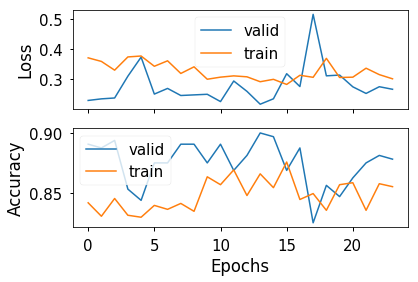

In [53]:
plot_loss(history_model)
print_score(model2,X_valid,X_angle_valid,y_valid,label='valid')

## Pretrained model
-start with VGG

In [54]:
epochs  = 50
vgg_base = VGG16(include_top=False,weights='imagenet')

58900480/58889256 [==============================] - 10s 0us/step


In [57]:
#use vgg model to generate predictions on the input, namely extract features 
vgg_valid_features = vgg_base.predict(X_valid,batch_size=batch_size)
np.save(open('vgg_valid_features.npy','w'),vgg_valid_features)

In [60]:
print(vgg_valid_features.shape)

(321, 2, 2, 512)


In [138]:
vgg_tr_features, tr_angles, tr_labels = get_vgg_features(X_train,X_angle_train,y_train,n_batches=100)

print(vgg_tr_features.shape)
print(tr_angles.shape)
print(tr_labels.shape)

(6220, 2, 2, 512)
(6220,)
(6220,)


In [113]:
#np.save(open('vgg_tr_features.npy','w'),vgg_tr_features)
#np.save(open('tr_angles.npy','w'),tr_angles)
#np.save(open('tr_labels.npy','w'),tr_labels)

In [137]:
def get_vgg_features(x_data,x_angle,y_label,n_batches=100):
    '''
    extract features from VGG16 model, batch by batch
    
    x_data: image data to be transformed
    x_angle: angle data (no transformation)
    y_label: label
    num_samples: number of samples
    '''
    
    features = np.zeros(shape=(num_samples,2,2,512))
    labels = np.zeros(shape=(num_samples,))
    angles = np.zeros(shape=(num_samples,))
    
    #apply image augmentation transformations
    generator = gen_flow_two_inputs(x_data, x_angle, y_label)  

    for r in range(n_batches):
        batch_inputs, batch_labels = generator.next()
        if r == 0:
            angles = batch_inputs[1]
            labels = batch_labels
            features = vgg_base.predict(batch_inputs[0])

        angles = np.concatenate((angles,batch_inputs[1]),axis=0)
        labels = np.concatenate((labels,batch_labels),axis=0)
        features = np.concatenate((features,vgg_base.predict(batch_inputs[0])),axis=0)

    return features,angles,labels

In [146]:
def fc_top_layer(dense_units=(1024,512),p_dropout=(0.5,0.1)):
    features_in = Input(shape=(2,2,512),name='input_features')
    angle_input = Input(shape=(1,), name='input_angle')
    
    flatten = Flatten(name='flatten')(features_in)
    #flatten = GlobalAveragePooling2D(name='flatten')(cnn)

    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    fc = concatenate([flatten, angle_input],axis=-1,name='concat')
    
    #fully connected layers
    fc = Dense(dense_units[0],activation='elu',name='fc_1')(fc)
    fc = Dropout(p_dropout[0],name='dropout_1')(fc)
    fc = Dense(dense_units[1],activation='elu',name='fc_2')(fc)
    fc = Dropout(p_dropout[1],name='dropout_2')(fc)
        
    output = Dense(1, activation='sigmoid',name='output')(fc)
    
    model = Model(inputs=[features_in, angle_input], outputs=output,name='fc_top')
    model.summary()

    return model
    

In [144]:
model3 = fc_top_layer()
model3.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

epochs = 50
model3.fit([vgg_tr_features,tr_angles],tr_labels,epochs=epochs,
           validation_data=([vgg_valid_features, X_angle_valid], y_valid),
           callbacks=callbacks)

(?, ?)
(?, ?)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     (None, 2, 2, 512)    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2048)         0           input_features[0][0]             
__________________________________________________________________________________________________
input_angle (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 2049)         0           flatten[0][0]                    
                                                                 input_angle[0][0]             

321/321 [==============================] - 0s 233us/step

valid score: 0.37
valid accuracy 80.69%:


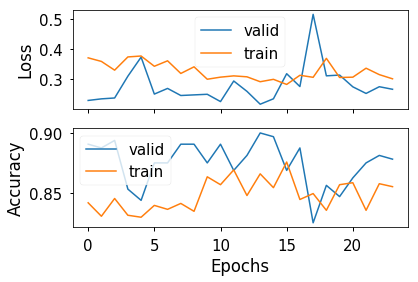

In [145]:
plot_loss(history_model)
print_score(model3,vgg_valid_features, X_angle_valid,y_valid,label='valid')

In [147]:
def gen_flow_two_inputs_vgg(img_data, angle_data, y_label):
    gen1 = gen.flow(img_data,y_label, batch_size=batch_size, seed=656)
    gen2 = gen.flow(img_data,angle_data, batch_size=batch_size, seed=656)
    
    while True:
        X1 = gen1.next()
        X2 = gen2.next()
        
        features = vgg_base.predict(X1[0])
        #return batches
        yield [features, X2[1]], X1[1]
        

In [ ]:
gen_flow_train = gen_flow_two_inputs_vgg(X_train, X_angle_train, y_train)

model3 = fc_top_layer(dense_units=(1024,512),p_dropout=(0.5,0.25))
model3.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

history_model = model3.fit_generator(gen_flow_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,
                                     callbacks=callbacks,
                                     validation_data=([vgg_valid_features, X_angle_valid], y_valid))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     (None, 2, 2, 512)    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2048)         0           input_features[0][0]             
__________________________________________________________________________________________________
input_angle (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 2049)         0           flatten[0][0]                    
                                                                 input_angle[0][0]                
__________

321/321 [==============================] - 0s 239us/step

valid score: 0.36
valid accuracy 81.31%:


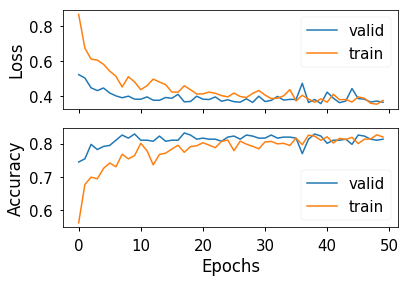

In [159]:
plot_loss(history_model)
print_score(model3,vgg_valid_features, X_angle_valid,y_valid,label='valid')

In [167]:
def vgg_coupled_model(dense_units = (1024,512),p_dropout = (0.5, 0.25)):
    img_input = Input(shape=X_train.shape[1:], name="image_input")
    angle_input = Input(shape=(1,), name="input_angle")

    vgg_base = VGG16(include_top=False,weights='imagenet')
    vgg_base.trainable=False  #lock layers, prevent training
    
    #vgg model
    features_out = vgg_base(img_input)
    flatten = Flatten(name='flatten')(features_out)

    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    fc = concatenate([flatten, angle_input],axis=-1,name='concat')

    #fully connected layers
    fc = Dense(dense_units[0],activation='elu',name='fc_1')(fc)
    fc = Dropout(p_dropout[0],name='dropout_1')(fc)
    fc = Dense(dense_units[1],activation='elu',name='fc_2')(fc)
    fc = Dropout(p_dropout[1],name='dropout_2')(fc)

    output = Dense(1, activation='sigmoid',name='output')(fc)

    model = Model(inputs=[img_input, angle_input], outputs=output,name='vgg_coupled_model')
    model.summary()

    return model

In [168]:
gen_flow_train = gen_flow_two_inputs(X_train, X_angle_train, y_train)

model4 = vgg_coupled_model()
model4.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

history_model = model4.fit_generator(gen_flow_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,
                                     callbacks=callbacks,
                                     validation_data=([X_valid, X_angle_valid], y_valid))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   multiple             14714688    image_input[0][0]                
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2048)         0           vgg16[3][0]                      
__________________________________________________________________________________________________
input_angle (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
concat (Co

321/321 [==============================] - 19s 61ms/step

valid score: 0.40
valid accuracy 81.31%:


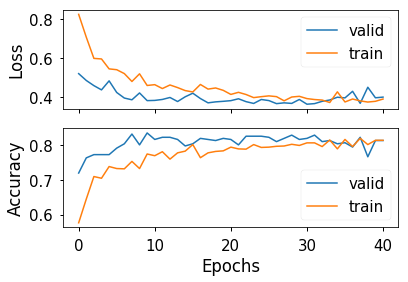

In [169]:
plot_loss(history_model)
print_score(model4,X_valid, X_angle_valid,y_valid,label='valid')

In [194]:
def get_logloss(model,y_label,x_data,x_angle):
    y_pred = model.predict([x_data,x_angle])
    score = log_loss(y_label,y_pred)
    
    return score

In [193]:
get_logloss(model4,y_valid,X_valid, X_angle_valid)

0.39983447996312199

In [170]:
def vgg_finetune_model(dense_units = (1024,512),p_dropout = (0.5, 0.25)):
    img_input = Input(shape=X_train.shape[1:], name="image_input")
    angle_input = Input(shape=(1,), name="input_angle")
    
    #load vgg conv base
    vgg_base = VGG16(include_top=False,weights='imagenet')
    vgg_base.trainable=True

    #lock all layers except conv bock 5
    set_trainable = False
    for layer in vgg_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    
    features_out = vgg_base(img_input)
    flatten = Flatten(name='flatten')(features_out)

    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    fc = concatenate([flatten, angle_input],axis=-1,name='concat')

    #fully connected layers
    fc = Dense(dense_units[0],activation='elu',name='fc_1')(fc)
    fc = Dropout(p_dropout[0],name='dropout_1')(fc)
    fc = Dense(dense_units[1],activation='elu',name='fc_2')(fc)
    fc = Dropout(p_dropout[1],name='dropout_2')(fc)

    output = Dense(1, activation='sigmoid',name='output')(fc)

    model = Model(inputs=[img_input, angle_input], outputs=output,name='vgg_coupled_model')
    model.summary()

    return model

In [ ]:
gen_flow_train = gen_flow_two_inputs(X_train, X_angle_train, y_train)

model5 = vgg_finetune_model()
model5.compile(optimizer=Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

history_model = model5.fit_generator(gen_flow_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,
                                     callbacks=callbacks,
                                     validation_data=([X_valid, X_angle_valid], y_valid))

In [17]:
non_zero_idxs = np.where(train.inc_angle>0)[0]

X_data = X_TRAIN[non_zero_idxs,...]
X_angles = X_ANGLE_TRAIN[non_zero_idxs,]
Y_labels = Y_TRAIN[non_zero_idxs,]


In [190]:
seeds = [256,656,818]

k_folds = 5
#folds = list(StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seeds[0]).split(X_data, y_labels))

train_len = len(non_zero_idxs)
inds = shuffle(np.array(range(train_len)),random_state=seeds[0])
split = 0.8
train_inds = inds[0:int(train_len*split)]
valid_inds = inds[int(train_len*split):]

X_data_train = X_data[train_inds,...]
X_angles_train = X_angles[train_inds,]
y_labels_train = Y_labels[train_inds,]

X_data_valid = X_data[valid_inds,...]
X_angles_valid = X_angles[valid_inds,]
y_labels_valid = Y_labels[valid_inds,]


In [195]:
model0 = cnn_model(base_filters=2,cnn_layers=4,dense_units=(1024,512))
model0.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

gen_flow_train = gen_flow_two_inputs(X_data_train, X_angles_train, y_labels_train,seed=256)

history_model = model0.fit_generator(gen_flow_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,
                                     callbacks=callbacks,
                                     validation_data=([X_data_valid, X_angles_valid], y_labels_valid))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 75, 75, 3)    0           image_input[0][0]                
__________________________________________________________________________________________________
bn_0 (BatchNormalization)       (None, 75, 75, 3)    300         permute[0][0]                    
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 75, 75, 16)   448         bn_0[0][0]                       
__________________________________________________________________________________________________
bn_1_1 (Ba

20/20 [==============================] - 83s 4s/step - loss: 0.4768 - acc: 0.7653 - val_loss: 0.8784 - val_acc: 0.5017
Epoch 7/50
20/20 [==============================] - 83s 4s/step - loss: 0.4782 - acc: 0.7674 - val_loss: 0.6319 - val_acc: 0.5763
Epoch 8/50
20/20 [==============================] - 83s 4s/step - loss: 0.4478 - acc: 0.7888 - val_loss: 0.7052 - val_acc: 0.5119
Epoch 9/50
20/20 [==============================] - 83s 4s/step - loss: 0.4436 - acc: 0.7852 - val_loss: 0.6364 - val_acc: 0.5525
Epoch 10/50
20/20 [==============================] - 83s 4s/step - loss: 0.4109 - acc: 0.8060 - val_loss: 0.6617 - val_acc: 0.5797
Epoch 11/50
20/20 [==============================] - 83s 4s/step - loss: 0.4418 - acc: 0.7855 - val_loss: 0.4731 - val_acc: 0.7525
Epoch 12/50
20/20 [==============================] - 83s 4s/step - loss: 0.3964 - acc: 0.8076 - val_loss: 0.4783 - val_acc: 0.7458
Epoch 13/50
20/20 [==============================] - 83s 4s/step - loss: 0.4218 - acc: 0.8027 - va

295/295 [==============================] - 9s 32ms/step

valid score: 0.26
valid accuracy 87.46%:


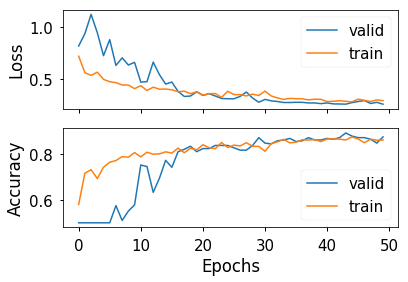

In [196]:
plot_loss(history_model)
print_score(model_0,X_data_valid, X_angles_valid,y_labels_valid,label='valid')


In [199]:
model_0.save_weights(model_path + 'model_jan17.h5')
prediction = model_0.predict([X_KagTest,X_KagTest_angle], verbose=1,batch_size=200)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission_filename = 'model_subm_jan17.csv'
submission.to_csv(submission_filename, index=False)

FileLink(submission_filename)

8424/8424 [==============================] - 272s 32ms/step


/home/odenigborig/Github/Kaggle/statoli_iceberg/model_subm_jan17.csv

The above submission resulted in LB score of 0.3

In [15]:
def cnn_model(img_input_shape=(75,75,3),base_filters=2,cnn_layers=4,p_dropout=(0.5,0.2), \
              dense_units=(1024,512),p_activation='relu'):
        
    img_input = Input(shape=img_input_shape, name="image_input")
    angle_input = Input(shape=(1,), name="input_angle")

    cnn = Permute([1,2,3],name='permute')(img_input)
    cnn = BatchNormalization(axis=1,name='bn_0')(cnn)

    for i in range(cnn_layers):
        cnn = Conv2D(filters=base_filters*2**(3+i), kernel_size=(3, 3), activation=p_activation, 
                     padding='same',name='conv_' + str(1+i) + '_1')(cnn)
        cnn = BatchNormalization(axis=1,name='bn_' + str(i+1) + '_1')(cnn)
        cnn = Conv2D(filters=base_filters*2**(3+i), kernel_size=(3, 3), activation=p_activation,
                     padding='same',  name='conv_' + str(1+i) + '_2')(cnn)
        cnn = BatchNormalization(axis=1,name='bn_' + str(i+1) + '_2')(cnn)

        #print(cnn._keras_shape)
        cnn = MaxPooling2D((2,2), strides=(2,2), name='max_pool_' + str(1+i))(cnn)
    
    cnn = Dropout(p_dropout,name='dropout_0')(cnn)
        #print(cnn._keras_shape)
    
    flatten = Flatten(name='flatten')(cnn)
    #flatten = GlobalAveragePooling2D(name='flatten')(cnn)
    #print(flatten._keras_shape)
    
    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    fc = concatenate([flatten, angle_input],axis=-1,name='concat')
    #print(merge._keras_shape)

    #fully connected layers
    for d in range(len(dense_units)):
        fc = Dense(dense_units[d],activation=p_activation,name='fully_connected_' + str(d+1))(fc)
        fc = Dropout(p_dropout[d],name='dropout_'+str(d+i+2))(fc)
        #print(fc._keras_shape)

    output = Dense(1, activation='sigmoid',name='output')(fc)
    #output = Dropout(p_dropout)(fc)
    #print(fc._keras_shape)

    model = Model(inputs=[img_input, angle_input], outputs=output,name='CNN')
    #model.summary()
    
    return model

In [59]:
np.random.randint(12883823//2,12883823*2,5)

array([12859208, 25276374, 16134925,  9437553, 13605697])

In [82]:
np.random.randint(0,1471,int(train_len*0.8))

array([595, 317, 343, ..., 568, 899, 830])

In [91]:
folds = list(StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seeds[0]).split(X_data, Y_labels))
for f in range(5):print(len(folds[f][1]))

295
295
295
293
293


In [ ]:
batch_size = 64
epochs = 100
patience = 25
path = os.getcwd()
model_path = path + '/models/'

#es = EarlyStopping('val_loss', patience=patience, mode="min")
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=1/3., patience=10, verbose=1, mode='min',epsilon=1e-4)   

#seeds = [12883823,4776725,8648796]
#seeds = np.random.randint(12883823//2,12883823*2,5)
seeds = [12859208, 25276374, 16134925,  9437553, 13605697]

k_folds = 5
folds = list(KFold(n_splits=k_folds, shuffle=True, random_state=seeds[0]).split(X_data, Y_labels))
y_test_pred_log= []
y_train_pred_log=[]
y_valid_pred_log= []#0.0*Y_labels
train_len = len(non_zero_idxs)

for j, (train_inds, valid_inds) in enumerate(folds):
    print('\n=================== FOLD: {} of {} ==================='.format(j+1,k_folds))
    
    X_data_train = X_data[train_inds,...]
    X_angles_train = X_angles[train_inds,]
    y_labels_train = Y_labels[train_inds,]

    X_data_valid = X_data[valid_inds,...]
    X_angles_valid = X_angles[valid_inds,]
    y_labels_valid = Y_labels[valid_inds,]
        
    file_name = "%s_cv_model_weights.hdf5"%j
    file_path = model_path + file_name

    msave = ModelCheckpoint(file_path, save_best_only=True, monitor='val_loss',mode='min')
    #callbacks = [es, msave, reduce_lr_loss]
    callbacks = [msave, reduce_lr_loss]
    
    gen_flow_train = gen_flow_two_inputs(X_data_train, X_angles_train, y_labels_train,seed=seeds[2])
    
    model_0 = cnn_model()
    model_0.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

    history_model = model_0.fit_generator(gen_flow_train,steps_per_epoch=train_len//batch_size,epochs=epochs,
                                         callbacks=callbacks,
                                         validation_data=([X_data_valid, X_angles_valid], y_labels_valid))
    
    model_0.load_weights(filepath=file_path)
    
    print_score(model_0,X_data_train, X_angles_train,y_labels_train,label='train')
    print_score(model_0,X_data_valid, X_angles_valid,y_labels_valid,label='valid')
    
    #Getting Validation Score.
    pred_valid=model_0.predict([X_data_valid,X_angles_valid])
    y_valid_pred_log.append(pred_valid.reshape(pred_valid.shape[0]))

    #Getting Kaggle Test Scores
    temp_test=model_0.predict([X_KagTest, X_KagTest_angle])
    y_test_pred_log.append(temp_test.reshape(temp_test.shape[0]))

    #Getting Train Scores
    temp_train=model_0.predict([X_data_train, X_angles_train])
    y_train_pred_log.append(temp_train.reshape(temp_train.shape[0]))
    



=================== FOLD= 0 of 5 ===================
Epoch 1/100
22/22 [==============================] - 102s 5s/step - loss: 0.7586 - acc: 0.6020 - val_loss: 0.7023 - val_acc: 0.5322
Epoch 2/100
22/22 [==============================] - 92s 4s/step - loss: 0.6054 - acc: 0.7050 - val_loss: 0.6946 - val_acc: 0.4678
Epoch 3/100
22/22 [==============================] - 92s 4s/step - loss: 0.5844 - acc: 0.7078 - val_loss: 0.7010 - val_acc: 0.4678
Epoch 4/100
22/22 [==============================] - 92s 4s/step - loss: 0.5280 - acc: 0.7420 - val_loss: 0.8225 - val_acc: 0.4678
Epoch 5/100
22/22 [==============================] - 92s 4s/step - loss: 0.5121 - acc: 0.7580 - val_loss: 0.8378 - val_acc: 0.4678
Epoch 6/100
22/22 [==============================] - 92s 4s/step - loss: 0.5102 - acc: 0.7480 - val_loss: 0.6955 - val_acc: 0.4678
Epoch 7/100
22/22 [==============================] - 89s 4s/step - loss: 0.4447 - acc: 0.7949 - val_loss: 0.8254 - val_acc: 0.4678
Epoch 8/100
22/22 [=========

295/295 [==============================] - 9s 32ms/step

valid score: 0.26
valid accuracy 87.12%:

=================== FOLD= 1 of 5 ===================
Epoch 1/100
22/22 [==============================] - 102s 5s/step - loss: 0.8203 - acc: 0.6289 - val_loss: 0.9836 - val_acc: 0.5034
Epoch 2/100
22/22 [==============================] - 92s 4s/step - loss: 0.6324 - acc: 0.6818 - val_loss: 0.9312 - val_acc: 0.5034
Epoch 3/100
22/22 [==============================] - 92s 4s/step - loss: 0.5945 - acc: 0.7124 - val_loss: 1.0543 - val_acc: 0.5034
Epoch 4/100
22/22 [==============================] - 92s 4s/step - loss: 0.5213 - acc: 0.7448 - val_loss: 1.0939 - val_acc: 0.5034
Epoch 5/100
22/22 [==============================] - 92s 4s/step - loss: 0.4893 - acc: 0.7586 - val_loss: 1.2233 - val_acc: 0.5034
Epoch 6/100
22/22 [==============================] - 92s 4s/step - loss: 0.4870 - acc: 0.7675 - val_loss: 1.2858 - val_acc: 0.5034
Epoch 7/100
22/22 [==============================] - 89s 4s/s

Epoch 10/100
22/22 [==============================] - 92s 4s/step - loss: 0.3703 - acc: 0.8219 - val_loss: 1.5782 - val_acc: 0.5272
Epoch 11/100
22/22 [==============================] - 92s 4s/step - loss: 0.3927 - acc: 0.8184 - val_loss: 1.4890 - val_acc: 0.5272
Epoch 12/100
22/22 [==============================] - 92s 4s/step - loss: 0.4003 - acc: 0.8020 - val_loss: 1.2701 - val_acc: 0.5306
Epoch 13/100
22/22 [==============================] - 89s 4s/step - loss: 0.4002 - acc: 0.8111 - val_loss: 1.2546 - val_acc: 0.5340
Epoch 14/100
22/22 [==============================] - 92s 4s/step - loss: 0.3727 - acc: 0.8159 - val_loss: 1.3143 - val_acc: 0.5374
Epoch 15/100
22/22 [==============================] - 92s 4s/step - loss: 0.3509 - acc: 0.8432 - val_loss: 0.7055 - val_acc: 0.6361
Epoch 16/100
22/22 [==============================] - 92s 4s/step - loss: 0.3583 - acc: 0.8312 - val_loss: 0.5585 - val_acc: 0.7245
Epoch 17/100
22/22 [==============================] - 92s 4s/step - loss: 0.

22/22 [==============================] - 92s 4s/step - loss: 0.2181 - acc: 0.9065 - val_loss: 0.3649 - val_acc: 0.8639
Epoch 74/100
22/22 [==============================] - 91s 4s/step - loss: 0.1960 - acc: 0.9175 - val_loss: 0.3838 - val_acc: 0.8707
Epoch 75/100
22/22 [==============================] - 92s 4s/step - loss: 0.2318 - acc: 0.9076 - val_loss: 0.3543 - val_acc: 0.8571
Epoch 76/100
22/22 [==============================] - 89s 4s/step - loss: 0.1980 - acc: 0.9128 - val_loss: 0.3447 - val_acc: 0.8707
Epoch 77/100
22/22 [==============================] - 92s 4s/step - loss: 0.1856 - acc: 0.9165 - val_loss: 0.3525 - val_acc: 0.8776
Epoch 78/100
22/22 [==============================] - 92s 4s/step - loss: 0.2259 - acc: 0.9041 - val_loss: 0.4342 - val_acc: 0.8503
Epoch 79/100
22/22 [==============================] - 92s 4s/step - loss: 0.2022 - acc: 0.9047 - val_loss: 0.4020 - val_acc: 0.8537
Epoch 80/100
22/22 [==============================] - 92s 4s/step - loss: 0.2131 - acc: 0

22/22 [==============================] - 89s 4s/step - loss: 0.3177 - acc: 0.8601 - val_loss: 0.3135 - val_acc: 0.8776
Epoch 33/100
22/22 [==============================] - 92s 4s/step - loss: 0.3332 - acc: 0.8429 - val_loss: 0.3009 - val_acc: 0.8673
Epoch 34/100
22/22 [==============================] - 91s 4s/step - loss: 0.3171 - acc: 0.8528 - val_loss: 0.3107 - val_acc: 0.8571
Epoch 35/100
22/22 [==============================] - 92s 4s/step - loss: 0.3322 - acc: 0.8390 - val_loss: 0.2911 - val_acc: 0.8741
Epoch 36/100
22/22 [==============================] - 92s 4s/step - loss: 0.3023 - acc: 0.8603 - val_loss: 0.2851 - val_acc: 0.8741
Epoch 37/100
22/22 [==============================] - 91s 4s/step - loss: 0.3075 - acc: 0.8621 - val_loss: 0.3188 - val_acc: 0.8333
Epoch 38/100
22/22 [==============================] - 89s 4s/step - loss: 0.2918 - acc: 0.8676 - val_loss: 0.3043 - val_acc: 0.8707
Epoch 39/100
22/22 [==============================] - 92s 4s/step - loss: 0.3089 - acc: 0

22/22 [==============================] - 92s 4s/step - loss: 0.3846 - acc: 0.8237 - val_loss: 1.0899 - val_acc: 0.5238
Epoch 15/100
22/22 [==============================] - 91s 4s/step - loss: 0.4049 - acc: 0.8095 - val_loss: 1.2336 - val_acc: 0.5204
Epoch 16/100
22/22 [==============================] - 92s 4s/step - loss: 0.3626 - acc: 0.8315 - val_loss: 0.7740 - val_acc: 0.5986
Epoch 17/100
22/22 [==============================] - 92s 4s/step - loss: 0.3490 - acc: 0.8422 - val_loss: 0.6615 - val_acc: 0.6327
Epoch 18/100
22/22 [==============================] - 92s 4s/step - loss: 0.3733 - acc: 0.8286 - val_loss: 0.6552 - val_acc: 0.6735
Epoch 19/100
22/22 [==============================] - 89s 4s/step - loss: 0.3604 - acc: 0.8349 - val_loss: 0.4070 - val_acc: 0.7993
Epoch 20/100
22/22 [==============================] - 92s 4s/step - loss: 0.3462 - acc: 0.8351 - val_loss: 0.4971 - val_acc: 0.7517
Epoch 21/100
22/22 [==============================] - 92s 4s/step - loss: 0.3525 - acc: 0

In [104]:
y_test = 0
for t in y_test_pred_log: y_test += t
prediction = y_test / k_folds

submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction})
submission_filename = 'cv_model_subm_jan18.csv'
submission.to_csv(submission_filename, index=False)

FileLink(submission_filename)

/home/odenigborig/Github/Kaggle/statoli_iceberg/cv_model_subm_jan18.csv

model above achieved LB score of 0.25

In [18]:
def cnn_model2(img_input_shape=(75,75,3)):
        
    img_input = Input(shape=img_input_shape, name="image_input")
    angle_input = Input(shape=(1,), name="input_angle")

    cnn = Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same',name='conv_1_1')(img_input)
    cnn = Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same',name='conv_1_2')(cnn)
    cnn = Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same',name='conv_1_3')(cnn)
    cnn = MaxPooling2D((3,3), strides=(2,2), name='max_pool_1')(cnn)

    cnn = Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same',name='conv_2_1')(cnn)
    cnn = Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same',name='conv_2_2')(cnn)
    cnn = Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same',name='conv_2_3')(cnn)
    cnn = MaxPooling2D((2,2), strides=(2,2), name='max_pool_2')(cnn)

    cnn = Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same',name='conv_3')(cnn)
    cnn = MaxPooling2D((2,2), strides=(2,2), name='max_pool_3')(cnn)
    
    cnn = Conv2D(filters=256, kernel_size=(3, 3), activation='relu',padding='same',name='conv_4')(cnn)
    cnn = MaxPooling2D((2,2), strides=(2,2), name='max_pool_4')(cnn)
    
    flatten = Flatten(name='flatten')(cnn)
    
    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    merge = concatenate([flatten, angle_input],axis=-1,name='concat')
    
    fc = Dense(1024,activation='relu',name='fc1')(merge)
    fc = Dropout(0.5,name='dropout_1')(fc)
    fc = Dense(512,activation='relu',name='fc2')(fc)
    fc = Dropout(0.2,name='dropout_2')(fc)
    
    output = Dense(1, activation='sigmoid',name='output')(fc)

    model = Model(inputs=[img_input, angle_input], outputs=output,name='CNN')
    #model.summary()
    
    return model

In [110]:
model_1 = cnn_model2()
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 75, 75, 64)   1792        image_input[0][0]                
__________________________________________________________________________________________________
conv_1_2 (Conv2D)               (None, 75, 75, 64)   36928       conv_1_1[0][0]                   
__________________________________________________________________________________________________
conv_1_3 (Conv2D)               (None, 75, 75, 64)   36928       conv_1_2[0][0]                   
__________________________________________________________________________________________________
max_pool_1

In [ ]:
#run longer, remove early stop
#generate only horizontal and vertical flip augmentations & 10 StratifiedKFold
#add additional augmentation: random crop, zoom, mild rotation


In [20]:
def get_more_imgs(imgs):
    
    more_imgs = []
    vert_flip_imgs = []
    horz_flip_imgs = []

    for i in range(0, imgs.shape[0]):
        ch1 = imgs[i,:,:,0]
        ch2 = imgs[i,:,:,1]
        ch3 = imgs[i,:,:,2]
        
        ch1_h = cv2.flip(ch1,0)
        ch1_v = cv2.flip(ch1,1)
        
        ch2_h = cv2.flip(ch2,0)
        ch2_v = cv2.flip(ch2,1)
        
        ch3_h = cv2.flip(ch3,0)
        ch3_v = cv2.flip(ch3,1)
        
        vert_flip_imgs.append(np.dstack((ch1_v,ch2_v,ch3_v)))
        horz_flip_imgs.append(np.dstack((ch1_h,ch2_h,ch3_h)))
        
    vert_flip_imgs = np.array(vert_flip_imgs)
    horz_flip_imgs = np.array(horz_flip_imgs)
    
    more_imgs = np.concatenate((imgs,vert_flip_imgs,horz_flip_imgs))
    
    return more_imgs


In [33]:
epochs = 30
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=1/3., patience=10, verbose=1, mode='min',epsilon=1e-4)   
batch_size=64

def run_cv(x_data,x_angle,y_label,seed=12859208,k_folds=5,fname='cnn_mod2'):
    
    folds = list(StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed).split(x_data, y_label))

    y_test_pred_log= []
    train_len = len(x_data)

    for j, (train_inds, valid_inds) in enumerate(folds):
        print('\n=================== FOLD: {} of {} ==================='.format(j+1,k_folds))

        X_data_train = x_data[train_inds,...]
        X_angles_train = x_angle[train_inds,]
        y_labels_train = y_label[train_inds,]

        X_data_valid = x_data[valid_inds,...]
        X_angles_valid = x_angle[valid_inds,]
        y_labels_valid = y_label[valid_inds,]

        file_name = fname + "%s_cv_model_weights.hdf5"%j
        file_path = model_path + file_name

        msave = ModelCheckpoint(file_path, save_best_only=True, monitor='val_loss',mode='min')
        #callbacks = [es, msave, reduce_lr_loss]
        callbacks = [msave, reduce_lr_loss]

        model = cnn_model2()
        model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
        model.fit([X_data_train,X_angles_train],y_labels_train,callbacks=callbacks,batch_size=batch_size,
                  validation_data=([X_data_valid,X_angles_valid],y_labels_valid),epochs=epochs)
    
        model.load_weights(filepath=file_path)

        print_score(model,X_data_train, X_angles_train,y_labels_train,label='train')
        print_score(model,X_data_valid, X_angles_valid,y_labels_valid,label='valid')

        #Getting Kaggle Test Scores
        temp_test=model.predict([X_KagTest, X_KagTest_angle])
        prediction = temp_test.reshape(temp_test.shape[0])
        y_test_pred_log.append(prediction)
        
        #save Kaggle submision
        submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction})
        submission_filename = 'cnn_model2_cv_%s_subm_jan20.csv'%(j+1)
        submission.to_csv(submission_filename, index=False)

        #FileLink(submission_filename)
        
    return y_test_pred_log

In [23]:
#generate more data
X_data_more = get_more_imgs(X_data)
print(X_data_more.shape)
Y_labels_more = np.concatenate((Y_labels,Y_labels,Y_labels))
print(Y_labels_more.shape)
X_angles_more = np.concatenate((X_angles,X_angles,X_angles))
print(X_angles_more.shape)

(4413, 75, 75, 3)
(4413,)
(4413,)


In [ ]:
kagtest_pred = run_cv(X_data_more,X_angles_more,Y_labels_more,k_folds=10,fname='cnn_mod2_run1_')


=================== FOLD: 1 of 10 ===================
Train on 3971 samples, validate on 442 samples
Epoch 1/35
3971/3971 [==============================] - 617s 155ms/step - loss: 0.6693 - acc: 0.6072 - val_loss: 0.5449 - val_acc: 0.7262
Epoch 2/35
3971/3971 [==============================] - 621s 156ms/step - loss: 0.5848 - acc: 0.6940 - val_loss: 0.5372 - val_acc: 0.7330
Epoch 3/35
3971/3971 [==============================] - 622s 157ms/step - loss: 0.5775 - acc: 0.7013 - val_loss: 0.5500 - val_acc: 0.6833
Epoch 4/35
3971/3971 [==============================] - 622s 157ms/step - loss: 0.5698 - acc: 0.7036 - val_loss: 0.5697 - val_acc: 0.7217
Epoch 5/35
3971/3971 [==============================] - 622s 157ms/step - loss: 0.5164 - acc: 0.7535 - val_loss: 0.4828 - val_acc: 0.7557
Epoch 6/35
3971/3971 [==============================] - 622s 157ms/step - loss: 0.4522 - acc: 0.7847 - val_loss: 0.3839 - val_acc: 0.8281
Epoch 7/35
3971/3971 [==============================] - 623s 157ms/ste

3971/3971 [==============================] - 629s 158ms/step - loss: 0.1543 - acc: 0.9358 - val_loss: 0.2380 - val_acc: 0.9072
Epoch 30/35
3971/3971 [==============================] - 629s 159ms/step - loss: 0.1666 - acc: 0.9335 - val_loss: 0.2318 - val_acc: 0.9186
Epoch 31/35
3971/3971 [==============================] - 630s 159ms/step - loss: 0.1672 - acc: 0.9315 - val_loss: 0.2107 - val_acc: 0.9231
Epoch 32/35
3971/3971 [==============================] - 629s 158ms/step - loss: 0.1518 - acc: 0.9353 - val_loss: 0.2132 - val_acc: 0.9253
Epoch 33/35
3971/3971 [==============================] - 630s 159ms/step - loss: 0.1281 - acc: 0.9464 - val_loss: 0.2162 - val_acc: 0.9208
Epoch 34/35
3971/3971 [==============================] - 630s 159ms/step - loss: 0.1376 - acc: 0.9426 - val_loss: 0.2071 - val_acc: 0.9299
Epoch 35/35
3971/3971 [==============================] - 187s 47ms/step

train score: 0.11
train accuracy 95.47%:
442/442 [==============================] - 21s 47ms/step

valid 

Epoch 34/35
3972/3972 [==============================] - 632s 159ms/step - loss: 0.1209 - acc: 0.9484 - val_loss: 0.2165 - val_acc: 0.9161
Epoch 35/35
3972/3972 [==============================] - 188s 47ms/step

train score: 0.16
train accuracy 92.62%:
441/441 [==============================] - 21s 47ms/step

valid score: 0.18
valid accuracy 93.65%:

=================== FOLD: 9 of 10 ===================
Train on 3972 samples, validate on 441 samples
Epoch 1/35
3972/3972 [==============================] - 633s 159ms/step - loss: 0.7128 - acc: 0.5398 - val_loss: 0.6910 - val_acc: 0.7075
Epoch 2/35
3972/3972 [==============================] - 630s 159ms/step - loss: 0.6141 - acc: 0.6702 - val_loss: 0.5730 - val_acc: 0.7143
Epoch 3/35
3972/3972 [==============================] - 631s 159ms/step - loss: 0.5842 - acc: 0.7072 - val_loss: 0.5621 - val_acc: 0.7324
Epoch 4/35
3972/3972 [==============================] - 631s 159ms/step - loss: 0.5777 - acc: 0.7034 - val_loss: 0.5229 - val_acc: 0

Epoch 19/35
3973/3973 [==============================] - 630s 159ms/step - loss: 0.2038 - acc: 0.9177 - val_loss: 0.2339 - val_acc: 0.9068
Epoch 20/35
3973/3973 [==============================] - 631s 159ms/step - loss: 0.2097 - acc: 0.9132 - val_loss: 0.2363 - val_acc: 0.8977
Epoch 21/35
3973/3973 [==============================] - 631s 159ms/step - loss: 0.1891 - acc: 0.9164 - val_loss: 0.2352 - val_acc: 0.8841
Epoch 22/35
3973/3973 [==============================] - 631s 159ms/step - loss: 0.1930 - acc: 0.9195 - val_loss: 0.2329 - val_acc: 0.8977
Epoch 23/35
3973/3973 [==============================] - 630s 158ms/step - loss: 0.1753 - acc: 0.9263 - val_loss: 0.2628 - val_acc: 0.8818
Epoch 24/35
3973/3973 [==============================] - 630s 159ms/step - loss: 0.1731 - acc: 0.9315 - val_loss: 0.2292 - val_acc: 0.9045
Epoch 25/35
3973/3973 [==============================] - 629s 158ms/step - loss: 0.1615 - acc: 0.9343 - val_loss: 0.2439 - val_acc: 0.9000
Epoch 26/35
3973/3973 [====

In [36]:
np.save('cv_kag_test_pred.npy',kagtest_pred)

In [38]:
y_test = 0
k_folds = 10
for t in kagtest_pred: y_test += t
prediction = y_test / k_folds

submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction})
submission_filename = 'cv_model2_subm_jan21.csv'
submission.to_csv(submission_filename, index=False)

FileLink(submission_filename)

/home/odenigborig/Github/Kaggle/statoli_iceberg/cv_model2_subm_jan21.csv

above LB score of 0.21

save individual submission files

In [45]:
for t,vals in enumerate(kagtest_pred): 
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': vals})
    submission_filename = 'cnn_model2_cv_%s_subm_jan21.csv'%(t+1)
    submission.to_csv(submission_filename, index=False)

In [46]:
!ls

4_layer_cnn_jan_13_no_dropout	  models
4_layer_cnn_jan_14_no_dropout.h5  stacking.ipynb
cnn_model2_cv_10_subm_jan21.csv   stack_minmax_median2.csv
cnn_model2_cv_1_subm_jan21.csv	  stack_minmax_median.csv
cnn_model2_cv_2_subm_jan21.csv	  statoli_iceberg.ipynb
cnn_model2_cv_3_subm_jan21.csv	  statoli_iceberg_v2.ipynb
cnn_model2_cv_4_subm_jan21.csv	  statoli_iceberg_v3.ipynb
cnn_model2_cv_5_subm_jan21.csv	  statoli_iceberg_v4.ipynb
cnn_model2_cv_6_subm_jan21.csv	  submission1.csv
cnn_model2_cv_7_subm_jan21.csv	  submission2.csv
cnn_model2_cv_8_subm_jan21.csv	  submission3.csv
cnn_model2_cv_9_subm_jan21.csv	  submission4.csv
cv_kag_test_pred.npy		  submission5.csv
mod2_subm1.csv			  submission6.csv
mod2_subm3.csv			  submission7.csv
mod2_subm4.csv			  submission8.csv
mod2_subm5.csv			  submission9.csv
model3_subm1.csv		  submission_others
model3_subm2.csv		  vgg_tr_features.npy
model3_subm3.csv		  vgg_valid_features.npy


In [ ]:
def cnn_model_sep(img_input_shape=(75,75,3),base_filters=2,cnn_layers=4,
                  p_dropout=(0,0),dense_units=(32,32),p_activation='elu'):
        
    img_input = Input(shape=img_input_shape, name="image_input")
    angle_input = Input(shape=(1,), name="input_angle")

    cnn = Permute([1,2,3],name='permute')(img_input)
    cnn = BatchNormalization(axis=1)(cnn)

    for i in range(cnn_layers):
        cnn = SeparableConv2D(filters=base_filters*2**(3+i), kernel_size=(3, 3), activation=p_activation, 
                              padding='same',name='conv_' + str(1+i) + '_1')(cnn)
        cnn = BatchNormalization(axis=1,name='bn_' + str(i+1) + '_1')(cnn)
        cnn = SeparableConv2D(filters=base_filters*2**(3+i), kernel_size=(3, 3), activation=p_activation,
                              padding='same',  name='conv_' + str(1+i) + '_2')(cnn)
        cnn = BatchNormalization(axis=1,name='bn_' + str(i+1) + '_2')(cnn)

        #print(cnn._keras_shape)
        cnn = MaxPooling2D((2,2), strides=(2,2), name='max_pool_' + str(1+i))(cnn)
        cnn = Dropout(p_dropout,name='dropout_'+str(i+1))(cnn)
        #print(cnn._keras_shape)

    flatten = Flatten(name='flatten')(cnn)
    #print(flatten._keras_shape)

    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    fc = concatenate([flatten, angle_input],axis=-1,name='concat')
    #print(merge._keras_shape)

    #fully connected layers
    for d in range(len(dense_units)):
        fc = Dense(dense_units[d],activation=p_activation,name='fully_connected_' + str(d+1))(fc)
        fc = Dropout(p_dropout[d],name='dropout_'+str(d+i+2))(fc)
        #print(fc._keras_shape)

    output = Dense(1, activation='sigmoid',name='output')(fc)
    #output = Dropout(p_dropout)(fc)
    #print(fc._keras_shape)

    model = Model(inputs=[img_input, angle_input], outputs=output,name='CNN')
    model.summary()
    
    return model



model2 = cnn_model_sep(base_filters=2,cnn_layers=4,dense_units=(1024,512))
model2.compile(optimizer=Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

history_model = model2.fit(x=[X_train, X_angle_train], y=y_train, epochs=epochs,
                           validation_data=([X_valid, X_angle_valid], y_valid), 
                           batch_size=batch_size, callbacks = callbacks,verbose=2)

plot_loss(history_model)
print_score(model2,X_valid,X_angle_valid,y_valid,label='valid')

The separable depthwise convolution model performs slightly better on hold on data (validation and internal test sets) than the previous model without regularisation. And yes it's overfitting. I can fix that with regularisation. Notice that the model also has fewer parameters than the previous model. This is due to the separable depthwise convolution. 